In [1]:
import os
import time

import re
from pathlib import Path

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

import cv2

import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
from google.colab import drive
# Mount to your Google Drive if using
drive.mount('/content/drive')

Mounted at /content/drive


#### Validate That GPU is Working

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

print(f"Tensorflow Version: {tf.version.VERSION}")

Found GPU at: /device:GPU:0
Tensorflow Version: 2.7.0


#### Set Location of Data and Models to Save
 These may be different for your set-up.

In [27]:
# Specify Location to Numpy Matrices of all of the Images
XTrainDataLocation = '/content/drive/My Drive/SCHOOL/ROB535/segmentedData/XTrain120by120SegmentedImages.npy'
YTrainDataLocation = '/content/drive/My Drive/SCHOOL/ROB535/segmentedData/YTrain120by120SegmentedImages.npy'
XTrainSummaryTable ='/content/drive/My Drive/SCHOOL/ROB535/segmentedData/summarizedTrainImages.parquet'

# Specify Location of Numpy Array Test Images that we do not know the Actual Class for. These were previously run through SSD Object Detector
XTestDataLocation = '/content/drive/My Drive/SCHOOL/ROB535/segmentedData/XTestthree_class_resnet50_v1_fpn_120821.npy'
XTestGUIDLocation = '/content/drive/My Drive/SCHOOL/ROB535/segmentedData/XTestGUIDthree_class_resnet50_v1_fpn_120821.npy'

exportedModelLocation ='/content/drive/My Drive/SCHOOL/ROB535/exported-models'

train_images_location = '/content/drive/My Drive/SCHOOL/ROB535/PerceptionFinalProject/trainval'

#### Set a Few Model Parameters

In [5]:
BATCH_SIZE = 200
EPOCHS = 50
val_perc_split = 0.1
test_perc_split = 0.05
description ='ResNet50_RegionModel'

exported_models_location = Path(exportedModelLocation)
exported_models_location.mkdir(exist_ok=True)

#### Load in Training Data

In [6]:
# Load in Data and Tables
X = np.load(XTrainDataLocation)
Y = np.load(YTrainDataLocation)

 # Read in Image Summary info
df_image_info = pd.read_parquet(XTrainSummaryTable)


# Update Height and Width
N, height, width, channels =  X.shape
yUnique = np.unique(Y)
NUnique = len(yUnique)

#### Create Folder to Export Model

In [7]:
# Create Model Description For Creating Metrics Later
model_descript = f'{description}_{int(val_perc_split*100)}PercValAnd{int(test_perc_split*100)}Test_{BATCH_SIZE}Batch_{NUnique}classes_{width}by{height}'


# Create Folder to Save Files
pathToModelSaveDir = Path(exported_models_location) / Path(model_descript)
pathToModelSaveDir.mkdir(exist_ok=True)

#### Plot Random Train Images

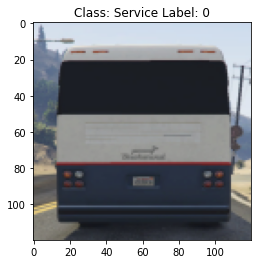

In [8]:
idx = np.random.randint(N)

className = df_image_info['class'].iloc[idx]
label = df_image_info['label'].iloc[idx]
test_img = X[idx,:,:,:]

plt.title(f"Class: {className} Label: {label}")
plt.imshow(test_img)
plt.show()

#### Split the Training Data and Do Augmentation

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    horizontal_flip=True,
    validation_split=val_perc_split)

# One Hot Encode Y Labels
y = tf.keras.utils.to_categorical(Y, num_classes=NUnique)

# Use a utility from sklearn to split and shuffle your dataset.
XTrain, XTest, YTrain,YTest,df_image_info_train,df_image_info_test = train_test_split(X, y,df_image_info,test_size=test_perc_split)

datagen.fit(XTrain)

print('Training Images shape:', XTrain.shape)
NTrain,_,_,_ = XTrain.shape
print('Test Images shape:', XTest.shape)


print(f"There are {NUnique} unique classes.")


Training Images shape: (7194, 120, 120, 3)
Test Images shape: (379, 120, 120, 3)
There are 3 unique classes.


#### View a Sample of the Augmented Data

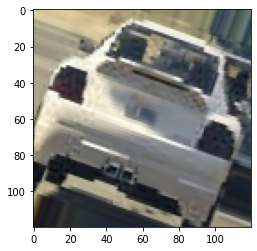

In [10]:
sample_train_image, sample_class = next(datagen.flow(XTrain, YTrain, batch_size=1,subset='training'))
plt.imshow(sample_train_image[0,:,:,:].astype(int))
plt.show()

#### Helper Functions

In [11]:
METRICS = [

      'accuracy',
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  base_model = tf.keras.applications.ResNet50(
    weights="imagenet", 
    include_top=False,
    input_shape=(height, width,3),
    
  )
  # Freeze all the layers Previously Learned
  for layer in base_model.layers[:2]:
      layer.trainable = False

  # Define Trainable Layers
  flatten_layer = layers.Flatten()
  dense_layer = layers.Dense(1024, activation='relu')
  drop_layer = layers.Dropout(0.2)
  prediction_layer = layers.Dense(NUnique, activation='softmax')



  # Add Base Model to New Layers
  model = models.Sequential([
      base_model,
      flatten_layer,
      dense_layer,
      drop_layer,
      prediction_layer
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=metrics)

  return model

def plot_metrics(history,save_file =None):
  metrics = ['loss', 'prc', 'precision', 'recall']
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
  if save_file is not None:
    plt.savefig(str(save_file))

def plot_cm(y_true, y_pred,save_file =None):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  if save_file is not None:
      plt.savefig(str(save_file))
def find_class_weights(Y):
  class_weights = {}

  y_max = np.max(Y)
  total = len(Y)

  for i in range(y_max + 1):
    NClass = sum(i == Y)
    weight_for_class = (1/NClass)*(total/2.0)
    class_weights[i] = weight_for_class

    print(f"Weight for class {i}: {weight_for_class:.2f}")

  return class_weights

def find_detections_in_image(test_images_location,df_image_info_test,idx,YIncorrectTestPredScore):
  

    testFileName = df_image_info_test['filename'].iloc[idx]
    ymin,xmin,ymax,xmax = df_image_info_test.loc[:,['min_y','min_x','max_y','max_x']].iloc[idx].tolist()
    label = df_image_info_test['label'].iloc[idx]
    pathToTestFile = Path(test_images_location) / Path(testFileName)

    image = np.array(Image.open(str(pathToTestFile)))
    H,W, _ = image.shape

    ymin,xmin,ymax,xmax = int(ymin),int(xmin),int(ymax),int(xmax)
    


    text = f"Class {label}"
    print(ymin)

    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (50, 168, 164), 4)
    cv2.putText(image, text, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50, 168, 164), 2) 
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.show()

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
callbacks_list = [early_stopping]

#### Create the Model

In [13]:
model = make_model()

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 57,146,243
Trainable params: 57,093,123
Non-trainable params: 53,120
________________________________________

### Start Training

In [14]:

history = model.fit(datagen.flow(XTrain, YTrain, batch_size=BATCH_SIZE,subset='training'), 
                    validation_data=datagen.flow(XTrain, YTrain, batch_size=BATCH_SIZE, subset='validation'),
                    epochs=EPOCHS,
                    callbacks=callbacks_list,               
                    class_weight=find_class_weights(np.argmax(YTrain,1))
                    )

Weight for class 0: 6.72
Weight for class 1: 0.79
Weight for class 2: 1.70
Epoch 1/50
33/33 [==============================] - 72s 2s/step - loss: 1.4343 - accuracy: 0.7578 - categorical_accuracy: 0.7578 - precision: 0.7649 - recall: 0.7506 - auc: 0.9084 - prc: 0.8363 - val_loss: 1.8214 - val_accuracy: 0.7524 - val_categorical_accuracy: 0.7524 - val_precision: 0.7556 - val_recall: 0.7524 - val_auc: 0.8680 - val_prc: 0.7635
Epoch 2/50
33/33 [==============================] - 47s 1s/step - loss: 0.3331 - accuracy: 0.8987 - categorical_accuracy: 0.8987 - precision: 0.9054 - recall: 0.8902 - auc: 0.9806 - prc: 0.9642 - val_loss: 0.4991 - val_accuracy: 0.8359 - val_categorical_accuracy: 0.8359 - val_precision: 0.8394 - val_recall: 0.8359 - val_auc: 0.9583 - val_prc: 0.9195
Epoch 3/50
33/33 [==============================] - 48s 1s/step - loss: 0.2010 - accuracy: 0.9302 - categorical_accuracy: 0.9302 - precision: 0.9342 - recall: 0.9282 - auc: 0.9918 - prc: 0.9846 - val_loss: 0.3495 - val_ac

#### Save and Show Plot Metrics

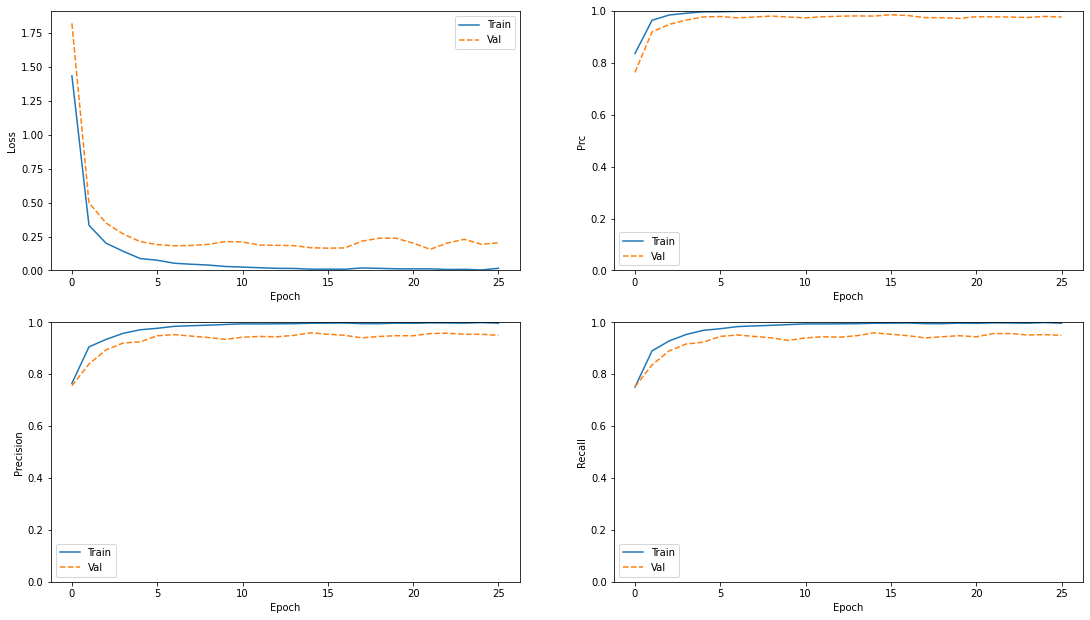

In [15]:

val_loss_metrics ='metrics.png'
pathToModelMetricsImage = pathToModelSaveDir / Path(val_loss_metrics)
plot_metrics(history,pathToModelMetricsImage)

#### Show Confusion Matrix of Hold Out Test Data

loss :  0.18641673028469086
accuracy :  0.9445910453796387
categorical_accuracy :  0.9445910453796387
precision :  0.9445910453796387
recall :  0.9445910453796387
auc :  0.990075945854187
prc :  0.9806126952171326



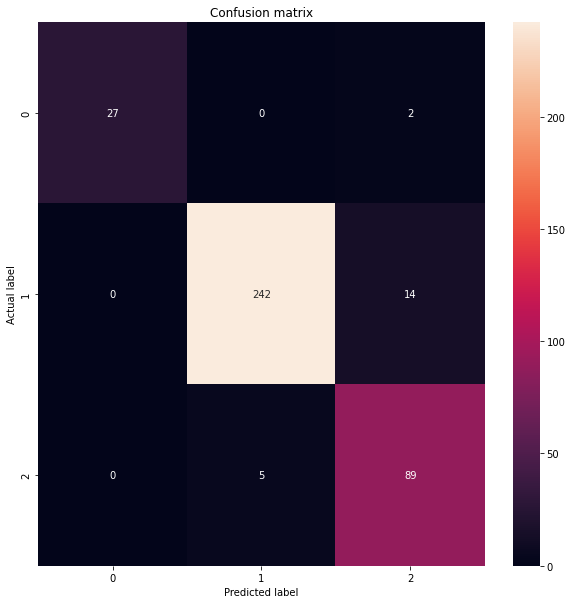

In [16]:
test_predictions_baseline = model.predict(XTest, batch_size=BATCH_SIZE)

YTestPred = np.argmax(test_predictions_baseline,1)
baseline_results = model.evaluate(XTest, YTest,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()
YTestAct = np.argmax(YTest,1)

confusion_matrix_image ='test_data_confusion_matrix.png'
pathToCMImage = pathToModelSaveDir / Path(confusion_matrix_image)

plot_cm(YTestAct, YTestPred,pathToCMImage)

#### Look at Random Images That Were Incorrectly Classified

There are incorrectly labeled classes 21
446


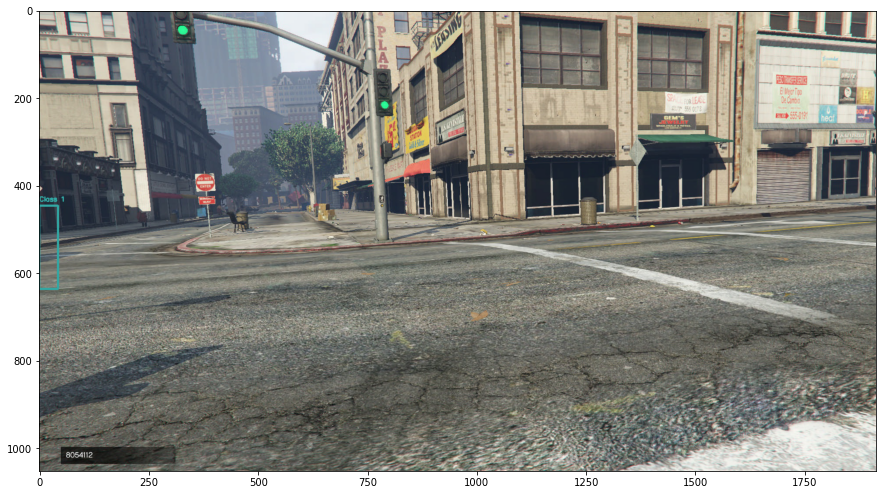

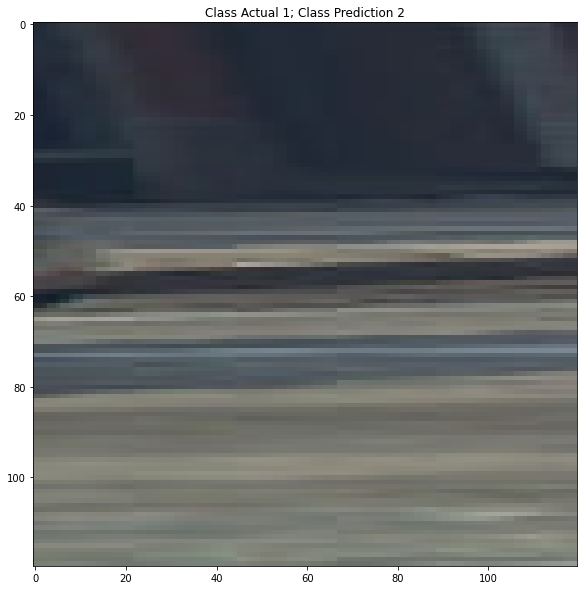

In [18]:
filterToIncorrectTest = YTestAct != YTestPred
XIncorrectTest = XTest[filterToIncorrectTest,:,:,:]
YIncorrectTestAct = YTestAct[filterToIncorrectTest]
YIncorrectTestPred = YTestPred[filterToIncorrectTest]
YIncorrectTestPredScore = np.max(YTest[filterToIncorrectTest,:])


NTest,_,_,_ = XIncorrectTest.shape
print(f"There are incorrectly labeled classes {NTest}")

# Choose Random Holdout Image Sample
# We held out a small percentage of data in order to validate model performance
idx = np.random.randint(NTest)


# Shows Full Sized Imaeg with Ground Truth Detection Box
find_detections_in_image(train_images_location,df_image_info_test[filterToIncorrectTest],idx,YIncorrectTestPredScore)

# Shows Regioned Image with Actual and Predicted Class
test_img = XIncorrectTest[idx,:,:,:]
plt.figure(figsize=(15,10))

plt.title(f"Class Actual {YIncorrectTestAct[idx]}; Class Prediction {YIncorrectTestPred[idx]}")
plt.imshow(test_img)
plt.show()

#### Save The Model

In [19]:
model.save(str(pathToModelSaveDir))

INFO:tensorflow:Assets written to: /content/drive/My Drive/SCHOOL/ROB535/exported-models/ResNet50_RegionModel_10PercValAnd5Test_200Batch_3classes_120by120/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### Load Test Images

In [28]:
# Test Images on Best Model
XTest = np.load(XTestDataLocation)
GUID = np.load(XTestGUIDLocation)

In [29]:
N, height, width, channels =  XTest.shape

### Run Inference

In [30]:
# Get Test Data Predictions
y_pred = model.predict(XTest)
y_hats = np.argmax(y_pred,1) # Grab the Predicted Class Label

In [31]:
# Create Pandas DataFrame
df_test_info = pd.DataFrame(zip(GUID,y_hats),columns=['guid/image','label'])
df_test_info.head()

,guid/image,label
0,e024982a-233f-45b4-a6ec-505f5b0c2649/0006,1
1,e024982a-233f-45b4-a6ec-505f5b0c2649/0012,1
2,e024982a-233f-45b4-a6ec-505f5b0c2649/0068,0
3,e024982a-233f-45b4-a6ec-505f5b0c2649/0033,1
4,e024982a-233f-45b4-a6ec-505f5b0c2649/0080,0


In [32]:
# Check Class Uniquenness
for l in df_test_info['label'].unique():
  print(f"{l}:\t{sum(l == df_test_info['label'].values)}")

1:	1699
0:	127
2:	805


#### Save Test Results to CSV

In [33]:
pathToCSVResults = pathToModelSaveDir / Path(f"{model_descript}SSD_OneClass120421Region.csv")
df_test_info.loc[:,['guid/image','label']].to_csv(pathToCSVResults,index=False)